# Properties of Haar-Random quantum states
Written by Vinay Ramasesh, November 2018

Comments/questions/errata welcome: ramasesh@berkeley.edu

This notebook is intended for students and researchers in the field of quantum information to gain some familiarity with random quantum states.  The idea of a random quantum state being drawn from the Haar measure (so-called Haar-random quantum states) is becoming more prevalent in the quantum information literature, especially in works looking at quantum characterization, verification, and validation (QCVV).  Our goal here is for those in the field, especially experimentalists, who haven't seen these concepts before, to feel comfortable when encountering these terms in the literature.  We avoid derivations here, focusing instead on numerical experiments.

** In one sentence, the message of this notebook is: *random* pure states are highly entangled! **

Basic familiarity with quantum information will be helpful for understanding this notebook, but beyond first-yethe bulk of the content should be accessible to those who have taken a first course in quantum mechanics, and have a good understanding of linear algebra and basic probability theory.

In [336]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

## How do you sample a uniform (pure) quantum state on a Hilbert space of dimension n?

First things first: let's look at how one can go about sampling a *pure* quantum state from the Haar measure.  When we talk about quantum states, the Haar measure is simply the probability distribution over pure quantum states which is invariant under unitary transformations. 
### Qubit case (n = 2)
We can get some intuition for this question by looking first at the case where $n$ = 2, that is, Haar-random *qubit* states.  A general qubit state:
* is specified by four real numbers, 
\begin{equation}
|\psi\rangle = \left(x_0 + i y_0\right) |0\rangle + \left(x_1 + i y_1\right) |1\rangle
\end{equation}
* subject to the normalization constraint $x_0^2 + x_1^2 + y_0^2 + y_1^2 = 1$, 
* and with the caveat that states which differ by an overall phase are the same quantum state.

We want to specify a joint probability distribution for $x_0, x_1, y_0, y_1$ such that all pure states are equally likely.  Since any set of four numbers that satisfies normalization should be equally likely, we can just write 
\begin{equation}
p(x_0, y_0, x_1, y_1) = \mathcal{N}\delta(x_0^2 + x_1^2 + y_0^2 + y_1^2 - 1),
\end{equation}
where $\mathcal{N}$ is simply a normalization constant. This is true in higher dimensions as well.  But how do we sample from such a distribution?

As you might expect, the way to understand this sampling is to exploit geometric intuition, and think of what you're doing as sampling uniformly from the surface of the unit-sphere of dimension $2N$ (where $N$ is the dimension of the Hibert space, *not* the number of qubits).  Note that sampling from this distribution is not trivial since the variables $x_0, x_1, y_0, y_1$ are not independent (because of the normalization constraint, i.e. that the sphere must have unit radius).  However, it turns out there's a nice trick to sample from a sphere of arbitrary dimension $M$:  you just generate $M$ independent, normally-distributed random variables and then normalize.  Think about why this works!  

With some numerical experiments, we can show that this method of sampling from a sphere works for the cases of $n = 2$:

In [4]:
def uniform_sphere_point(dimension = 2, num_points = 100):
    """ Generates a uniformly-sampled point from the surface of a unit-sphere with the specified dimension """
    
    # as described above, we first generate a set of random, independent realizations of a gaussian randomv variable
    # because these points are independently generated, they won't satisfy the normalization condition
    initial_points = np.random.randn(dimension, num_points) 
    
    # Next, we simply normalize each point such that it lies on the unit sphere
    radii = np.sqrt(np.sum(initial_points**2, axis = 0))
    normalized_points = initial_points / radii
    return normalized_points

Run the following cell a few times to see that indeed, we are sampling from a 1-sphere (circle).

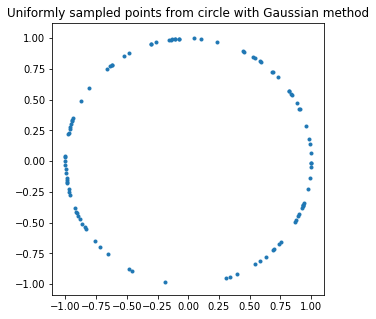

In [340]:
plt.figure(figsize = (5,5))
plt.scatter(*uniform_sphere_point(), marker = '.')
plt.axis('square');
plt.title('Uniformly sampled points from circle with Gaussian method');

#### Checking uniform sampling via angles

To check that we are properly sampling uniformly from the circle, we can take each point and calculate the angle it forms to the x-axis.  As the number of points grows, the distribution of angles should approach the uniform distribution on the interval $[-\pi, \pi)$.  

In [339]:
def angles(n_points):
    """ samples n_points from a circle using the method and returns their angles on the interval [-pi,pi]"""
    sampled_points = uniform_sphere_point(dimension = 2, num_points = n_points)
    angles = np.angle(sampled_points[0] + 1j*sampled_points[1])
    
    return angles

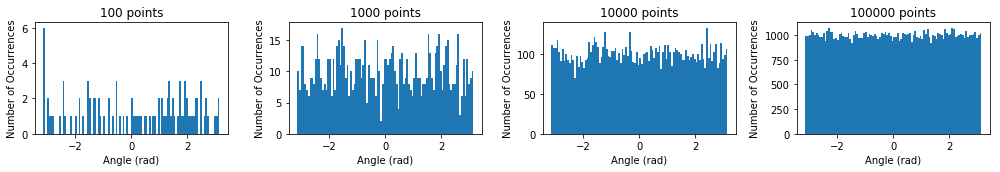

In [68]:
number_of_points = [100,1000,10000,100000]

plt.figure(figsize = (14,2.5))
for i,n_points in enumerate(number_of_points):
    plt.subplot(1,len(number_of_points),i+1)
    plt.hist(angles(n_points), bins = 100, range = np.array([-np.pi,np.pi]));
    plt.title('{} points'.format(n_points))
    plt.xlabel('Angle (rad)')
    plt.ylabel('Number of Occurrences')
plt.tight_layout()

Play with the above cell a few times, and you should convince yourself that we have indeed properly sampled from a circle using this method.

Having convinced ourselves that we have a good method for sampling from a sphere of arbitrary dimension, we will use this method to generate random pure states for arbitrary-dimensioned systems, and explore some of their properties.  

## Properties of Haar-Random states
### 1. Uniform pure states on a bipartite system are almost always entangled

It turns out that if you generate a pure state of a bipartite (say, $N \times K$ dimensional) system, the states are almost always entangled.  One way to think about this is to think about the dimension of the relevant Hilbert spaces.  As we discussed earlier, pure states of the $N \times K$ dimensional system occupy the surface of a sphere with $(2 \times N \times K)$ dimensions.  Removing one dimension since the overall phase is irrelevant gives $2NK - 1$.  By similar logic, pure states of the $N$ dimensional system (with the overall phase taken out) occupy a manifold of $2N-1$ dimensions, while pure states of the K dimensional system occupy a manifold of $2K-1$ dimensions.  That means that the dimension of the set of of pure states in the $N \times K$ dimensional space is the sum of the above two dimensions, i.e. $2N + 2K - 2$.  This is generally less than the dimension of the full Hilbert space, which we said above was $2NK - 1$.  

For example in the qubit-qubit case, where $N = K = 2$, the space of pure states is 3-dimensional, whereas the space of all states is 7-dimensional.  So if you uniformly sample from the 7-dimensional space, you'll almost never see a pure state. 

Let's do some numerics to investigate the entanglement entropy of a random qubit entangled with another system (i.e. a $2$ x $N$ dimensional) state, i.e. the entropy when you trace out the thing that's not the qubit.  (Note: we use some helper functions here, defined and explained in the final section of this notebook.)

In [110]:
n_states = 100
dim_sys1 = 2
entropies = np.zeros(n_states)

for dim_sys2 in [2, 5, 12]:
    
    for i in range(n_states):

        # generate a random pure state
        psi = random_pure_state(dim_sys1*dim_sys2)

        # convert it into a density matrix
        rho = vec_to_dm(psi)

        # take the partial trace to get the density matrix of system 1 only
        rho_reduced = partial_trace(rho, dim = [dim_sys1, dim_sys2])

        # calculate the entanglement entropy
        entropies[i] = entropy(rho_reduced)

    print('System 1 dimension: {}, System 2 dimension: {}'.format(dim_sys1, dim_sys2))
    print('     The mean of the entanglement entropies is {:.2f}, with stdev {:.2f}'.format(np.mean(entropies), np.std(entropies)))
    print('     Note the maximal entropy for this subsystem dimension is {:.2f}'.format(np.log2(dim_sys1)))

System 1 dimension: 2, System 2 dimension: 2
     The mean of the entanglement entropies is 0.46, with stdev 0.28
     Note the maximal entropy for this subsystem dimension is 1.00
System 1 dimension: 2, System 2 dimension: 5
     The mean of the entanglement entropies is 0.76, with stdev 0.15
     Note the maximal entropy for this subsystem dimension is 1.00
System 1 dimension: 2, System 2 dimension: 12
     The mean of the entanglement entropies is 0.92, with stdev 0.07
     Note the maximal entropy for this subsystem dimension is 1.00


Playing with the above cell a few times (modify the values used for dim_sys2) should convince you that as the size of the second, traced-out subsystem increases, the entropy of the remaining system approaches its maximal value of $\log_2(N_1)$, where $N_1$ is the dimension of the first subsystem.

### 2. Page's formula for the average entropy of a subsystem
The above observation, that for a Haar-random total state, the average entropy of a subsystem increases as the size of its complement increases, can be made more quantitative.  Don Page has derived this approximate formula in this [PRL](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.71.1291):
\begin{equation}
S(N_1,N_2) \approx \log{N_1} - \frac{N_1}{2N_2},
\end{equation}
where here $N_1$ and $N_2$ are the dimensions of systems 1 and 2, respectively, and $S(N_1, N_2)$ is the average entropy of the subsystem of dimension $N_1$.  This approximation is valid when both $N_1 \gg 1$ and $N_2 \gg 1$, and when $N_1 < N_2$.  

Note that $\log{N_1}$ is the maximal possible entropy system 1 can have!  Thus what Page's formula says is that the deviation from maximal entropy is given by $\frac{N_1}{2N_2}$.  

Let us now verify Page's formula numerically.  Below, we define two functions, 
* avg_entropy(), which calculates numerically the average entropy of a bipartite system, and
* avg_entropy_Page(), which evaluates Page's formula given above

In [111]:
def avg_entropy(dim_sys1, dim_sys2, n_states = 100):
    """ returns the average entropy (averaged over n_states randomly-generated pure states of dimension dim_sys1*dim_sys2)
        of the reduced density matrix one obtains by tracing out system 2 """
    
    entropies = np.zeros(n_states)
    
    for i in range(n_states):
        psi = random_pure_state(dim_sys1*dim_sys2)
        rho = vec_to_dm(psi)
        rho_reduced = partial_trace(rho, dim = [dim_sys1, dim_sys2])
        entropies[i] = entropy(rho_reduced)
    
    return np.mean(entropies)

def avg_entropy_Page(dim_sys1, dim_sys2):
    """ returns the average entropy (calculated via Don Page's approximate formula) 
        for a pure state of dimension dim_sys1 * dim_sys2
        """
    
    return (np.log(dim_sys1) - dim_sys1/(2.*dim_sys2))/np.log(2)

We evaluate both of these functions for the case of a qubit (dim = 2) entangled with a system of size ranging from 2 to 11:

In [112]:
dims_sys2 = np.arange(2, 11)
dim_sys1 = 2
qubit_entropies = [avg_entropy(dim_sys1, int(n), n_states = 1000) for n in dims_sys2]
qubit_entropies_Page = [avg_entropy_Page(dim_sys1, int(n)) for n in dims_sys2]

Text(4,0.96,'Maximum Possible Entropy')

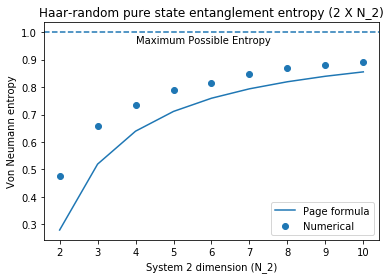

In [128]:
plt.scatter(dims_sys2, qubit_entropies, label = 'Numerical')
plt.plot(dims_sys2, qubit_entropies_Page, label = 'Page formula')
plt.title('Haar-random pure state entanglement entropy ({} X N_2)'.format(dim_sys1))
plt.xlabel('System 2 dimension (N_2)')
plt.ylabel('Von Neumann entropy')
plt.legend(loc = 4)
plt.axhline(np.log2(dim_sys1), linestyle = 'dashed')
plt.text(x = 4, y = 0.96, s = 'Maximum Possible Entropy', withdash = True)

Here we can see the good agreement between Page's formula and our numerics.

### 3. How entangled are two qubits on average?

Experimentalists in quantum computing are likely to be quite familiar with single-qubit density matrices.  To give some concrete intuition for the case of two qubits, let's find an impure single-qubit density matrix which has similar entropy to one that arises on average from a two-qubit Haar random state.

First, we calculate the average entropy of a two-qubit state.

In [61]:
avg_entropy(2,2, n_states = 10000)

0.48422185685387192

Let's see what sort of density matrix would have this sort of von Neumann entropy.  That is, what should the off-diagional terms be?

In [129]:
sys_dim = 2
coherence = 0.8
dm = (np.eye(sys_dim) + coherence * np.array([[0,1],[1,0]]))/sys_dim

In [130]:
dm

array([[0.5, 0.4],
       [0.4, 0.5]])

In [132]:
entropy(dm)

0.46899559358928156

So it looks like the generic value of the off diagonal element's magnitude is roughly 80 percent of the pure-state value.

### 4. Haar-random 2-qubit states trace out to a uniform distribution on *mixed* single-qubit states

Say we take two qubits, generate a Haar-random pure two-qubit state, and trace out one of the qubits to get a single-qubit density matrix.  This operation defines a probability distribution on the space of single-qubit density matrices.  What does such a distribution look like?  

Let's play around a bit numerically to find out.

In [168]:
n_states_2q = 1000
radii = np.empty((n_states_2q, ))

for i in range(n_states_2q):
    psi = random_pure_state(dim = 4) # 2-qubit pure state
    rho = vec_to_dm(psi)
    rho_reduced = partial_trace(rho, dim = [2,2])
    radii[i] = dm_to_r(rho_reduced)

We've generated a bunch of single-qubit Bloch vectors according to the procedure described above.  Let's histogram them to see how they look:

Text(0,0.5,'Frequency')

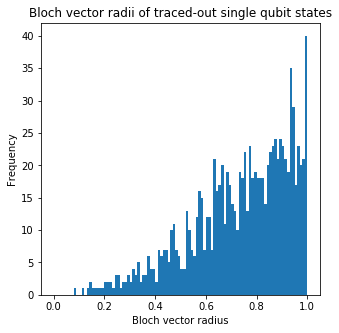

In [169]:
plt.figure(figsize = (5,5))
plt.hist(radii, bins = 100, range = [0,1]);
plt.title('Bloch vector radii of traced-out single qubit states')
plt.xlabel('Bloch vector radius')
plt.ylabel('Frequency')

Interesting!  This looks like it might be quadratic.  Let's take more data to find out.

In [170]:
n_states_2q = 10000
radii = np.empty((n_states_2q, ))

for i in range(n_states_2q):
    psi = random_pure_state(dim = 4) # 2-qubit pure state
    rho = vec_to_dm(psi)
    rho_reduced = partial_trace(rho, dim = [2,2])
    radii[i] = dm_to_r(rho_reduced)

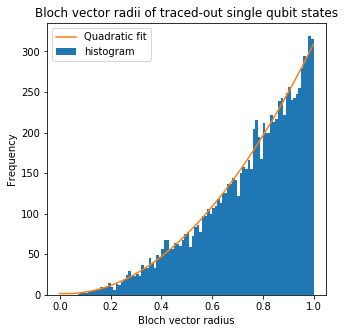

In [184]:
plt.figure(figsize = (5,5))
xy_bv = plt.hist(radii, bins = 100, range = [0,1], label = 'histogram');
plt.title('Bloch vector radii of traced-out single qubit states')
plt.xlabel('Bloch vector radius')
plt.ylabel('Frequency')

#fit the histogram to a quadratic and overlay it
a, b, c = np.polyfit(xy_bv[1][:-1], xy_bv[0], deg = 2)

x_fit = np.linspace(0,1,100)
plt.plot(x_fit, a*x_fit*x_fit + b*x_fit + c, label = 'Quadratic fit')

plt.legend(loc = 2)

We can see above that the quadratic fit matches the data perfectly.  This means that, since we expect the induced distribution to be invariant to rotations, that the induced distribution uniformly covers the Bloch sphere!  This is a remarkable result:  __If we generate a density matrix by generating a Haar-random 2-qubit state, and trace out one of the qubits, we uniformly sample points on the (interior + surface) of the Bloch sphere!__

This result can be analytically proven, as done in [this paper](https://arxiv.org/pdf/quant-ph/0012101.pdf) by Zyczkowski and Sommers.  In fact, it holds not just for two-qubit systems, but for any size bipartite system of equal dimension, i.e. for any two-qu*d*it system.  For those familiar with analysis, the resulting measure on the sphere is known as the Lebesgue or Borel measure.  

### 5. Qubit entangled with an N-dimensional system: von Neumann entropy distribution

We saw above, both numerically and via Page's formula, that for a qubit entangled with an $N$-dimensional system (with the whole system in a Haar-random pure state) the average entropy of the qubit state alone increases as $N$ increases.  Let's see how the distribution of entropy itself (not just its average value) looks for varying sizes $N$.   We'd expect that entropy distribution to shift to higher and higher values as the dimension of the second system increases.  But, I don't know of any analytic result for this, so it's in some sense just for fun. 

In [189]:
n_random_states = 10000
dim_sys1 = 2
dim_sys2 = 3

bin_edges = np.linspace(0,1,100)
bin_centers = (bin_edges + 0.005)[:-1]
qubit_entropy_distribution = {}

dim_sys2_array = [2,4,10,14]

for dim_sys2 in dim_sys2_array:
    entropies_temp = np.zeros(n_random_states)

    for i in range(n_random_states):
        psi = random_pure_state(dim_sys1*dim_sys2)
        rho = vec_to_dm(psi)
        rho_reduced = partial_trace(rho, dim = [dim_sys1, dim_sys2])
        entropies_temp[i] = entropy(rho_reduced)
        
        qubit_entropy_distribution[dim_sys2] = np.histogram(entropies_temp, bins = bin_edges, density = True)[0]

Text(0,0.5,'Probability density')

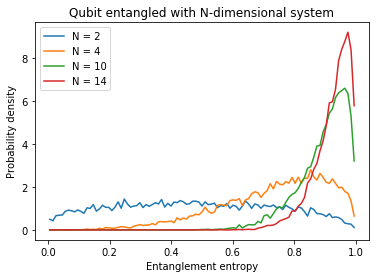

In [190]:
for j in dim_sys2_array:
    plt.plot(bin_centers,qubit_entropy_distribution[j], label = 'N = {}'.format(j))
plt.legend(loc = 2)
plt.title('Qubit entangled with N-dimensional system')
plt.xlabel('Entanglement entropy')
plt.ylabel('Probability density')

This looks more or less as expected, except I would have expected it to be monotonically increasing.  Not sure what is responsible for this downturn at the end. 

### 6.  A Haar-random pure state is almost maximally entangled with respect to any bipartition

Take any random pure state of a Hilbert space of dimension $d$, and subdivide that Hilbert space into two subspaces of dimension $d_1$ and $d_2$ such that $d_1 d_2 = d$.  No matter how you choose to partition the subspace, it turns out that the pure state you've sampled is likely to be nearly maximally entangled.  

Here, we will specialize to $2n$-qubit Hilbert spaces, and to *balanced* bipartitions, that is, partitions into two equal $n$-qubit Hilbert spaces.  

In [327]:
n_qubits = 4

psi = random_pure_state(dim = 2**(2*n_qubits))

Now that we've generated the state, let's evaluate the entropy with respect to randomly chosen bipartitions.  There should be a way to enumerate all the bipartitions of a given set, but at the moment I'm not able to think of it, so for now we'll just randomly generate bipartitions by choosing $n$ qubits to keep from the set of $2n$.  This can be done with numpy's random.choice method.  

In [328]:
qubits_to_keep = sorted(np.random.choice(range(2*n_qubits), size = n_qubits, replace = False))

Then, since our partial trace method likes the systems to be grouped such that we can just trace out one side, we swap the states such that the states of the qubits in 'qubits_to_keep' end up on the 'left', and the states of the other qubits end up on the 'right'.  

In [329]:
def entropy_of_subsystem(psi, n_qubits, qubits_to_keep):
    psi_tensor = np.array(psi).reshape(tuple([2]*2*n_qubits))
    for i in range(n_qubits):
        psi_tensor = np.swapaxes(psi_tensor, i, qubits_to_keep[i])
    psi_tensor = psi_tensor.reshape(2**(2*n_qubits))

    rho_total = vec_to_dm(psi_tensor)
    rho_reduced = partial_trace(rho_total, 1, dim = [[2**n_qubits, 2**n_qubits], [2**n_qubits, 2**n_qubits]])
    return entropy(rho_reduced)

Now we can use this method to verify the statement for different bipartitions.  Remember for an $n$-qubit density matrix, the maximum entropy is simply given by (using $2$ as the base of the logarithm) $n$.

In [332]:
n_realizations = 20

psi = random_pure_state(dim = 2**(2*n_qubits))

for _ in range(n_realizations):
    qubits_to_keep = sorted(np.random.choice(range(2*n_qubits), size = n_qubits, replace = False))
    print('Keeping qubits {}'.format(qubits_to_keep))
    print('Resulting entropy: {:.2f}'.format(entropy_of_subsystem(psi, n_qubits, qubits_to_keep)))

Keeping qubits [1, 4, 5, 7]
Resulting entropy: 3.32
Keeping qubits [0, 2, 6, 7]
Resulting entropy: 3.22
Keeping qubits [0, 4, 5, 6]
Resulting entropy: 3.25
Keeping qubits [2, 3, 6, 7]
Resulting entropy: 3.27
Keeping qubits [1, 4, 5, 6]
Resulting entropy: 3.30
Keeping qubits [0, 4, 5, 6]
Resulting entropy: 3.25
Keeping qubits [0, 3, 4, 5]
Resulting entropy: 3.28
Keeping qubits [2, 3, 6, 7]
Resulting entropy: 3.27
Keeping qubits [2, 3, 6, 7]
Resulting entropy: 3.27
Keeping qubits [0, 1, 4, 5]
Resulting entropy: 3.27
Keeping qubits [0, 3, 4, 5]
Resulting entropy: 3.28
Keeping qubits [0, 1, 4, 5]
Resulting entropy: 3.27
Keeping qubits [0, 1, 5, 7]
Resulting entropy: 3.34
Keeping qubits [0, 3, 4, 5]
Resulting entropy: 3.28
Keeping qubits [1, 2, 3, 4]
Resulting entropy: 3.32
Keeping qubits [3, 4, 6, 7]
Resulting entropy: 3.29
Keeping qubits [1, 3, 5, 6]
Resulting entropy: 3.29
Keeping qubits [0, 1, 2, 5]
Resulting entropy: 3.29
Keeping qubits [1, 4, 6, 7]
Resulting entropy: 3.33
Keeping qubi

### 7. Most Haar-random pure states too highly entangled to be useful in measurement-based quantum computation
#### (What we will actually explore: in a high-dimensional complex space, most normalized vectors are very nearly orthogonal)
In measurement-based quantum computing, a classical computer is given the ability to perform measurements on a pure quantum state of a composite Hilbert space.  It turns out that the measurement-based model of quantum computing is computationally universal, in the sense that certain states enable a classical computer to efficiently solve any problem in the complexity class BQP.  A natural guess as to what feature of these quantum states allow for the computational speedup is *entanglement*.  However, as shown in a 2008 paper, this is *not* the case.  

The title of the paper says it succinctly: [Most quantum states are too entangled to be useful as computational resources](https://arxiv.org/pdf/0810.4331.pdf).

In the paper, instead of using entanglement entropy as a measure of entanglement, they use a different measure called the [Geometric measure of entanglement](https://en.wikipedia.org/wiki/Geometric_measure_of_entanglement) $E _ { g } ( | \Psi \rangle )$, defined as follows:

\begin{equation}
E _ { g } ( | \Psi \rangle ) = - \log _ { 2 } \sup _ { \alpha \in \mathcal { P } } | \langle \alpha | \Psi \rangle | ^ { 2 }
\end{equation}

here, $\mathcal{P}$ is the set of all *product* states.  Essentially, we're finding the maximum overlap that any product state can have with the state of interest.

The paper above proves that if a family of states $\{ | \Psi_n\rangle \}$ **cannot** provide a super-polynomial speedup over classical algorithms if its entanglement measure takes the form $E _ { g } ( | \Psi _ { n } \rangle ) = n - O \left( \log _ { 2 } ( n ) \right)$.  We won't go over the proof here; it is theorem 1 in the paper.  

Theorem 2 proves that *most* Haar-random states in fact do have at least this value of the geometric measure of entanglement.  For random pure states on $n$ qubits where $n > 11$, the fraction of states which have *less* entanglement than this (i.e. the fraction of states which are potentially computationally useful) scales as $\exp{(-n^2)}$.  We won't prove theorem 2 here either.  The proof in the paper does rely on one result which we will explore, though, and it's of a different flavor than the previous properties we've discussed.  Namely, it concerns the overlap of a Haar-random pure state with an arbitrary quantum state.  

Specifically, given a $d$-dimensional Hilbert space and a particular quantum state $|\Phi\rangle$, we draw $|\Psi\rangle$ from the Haar measure.  Then, it turns out that their overlap is quite small:
\begin{equation}
\operatorname { Prob } \left\{ | \langle \Phi | \Psi \rangle | ^ { 2 } \geq \varepsilon \right\} < \exp ( - (d - 1 ) \varepsilon )
\end{equation}
(Note in the paper they write $2d$ instead of $d$; that's because they call $d$ the dimension of the complex vector, not the Hilbert space).  This is what we wrote in the subheading above:  in a high-dimensional complex space, most normalized vectors are nearly orthogonal.  

Let's numerically explore this inequality:

In [265]:
d = 20

# Without loss of generality, let us take Phi to be the vector with a single unit entry
Psi = np.zeros(d)
Psi[0] = 1

n_realizations = 10000
overlaps = np.empty((n_realizations,))

for i in range(n_realizations):
    # Now we generate Psi
    Phi = random_pure_state(dim = d)
    overlap = np.power(np.abs(np.dot(Psi,Phi)),2)
    overlaps[i] = overlap
    
# Now we numerically evaluate the probability density function of the overlap    
pdf_overlap, bins = np.histogram(overlaps, bins = 100, range = [0,1], density = True)

# Since the inequality concerns the integral of the pdf from epsilon to unity, we calculate that now
# we call it a cdf, though it's not really a cumulative distribution function
cdf_overlap = np.array([sum(pdf_overlap[i:]) for i in range(len(pdf_overlap))])/len(bins)

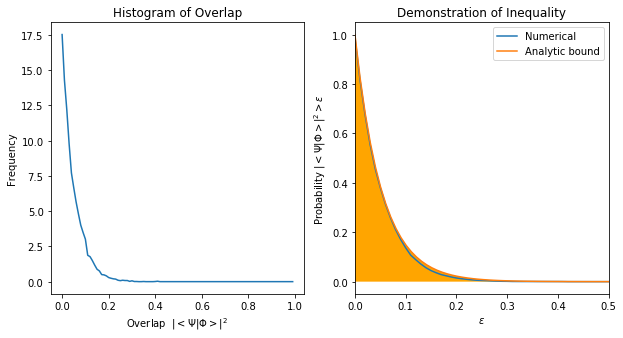

In [266]:
plt.figure(figsize = (10,5))
plt.subplot(1,2,1)
plt.plot(bins[:-1], pdf_overlap)
plt.xlabel('Overlap  $| <\Psi | \Phi> |^2$')
plt.ylabel('Frequency')
plt.title('Histogram of Overlap')

plt.subplot(1,2,2)
plt.plot(bins[:-1], cdf_overlap, label = 'Numerical')
plt.xlabel('$\epsilon$')
plt.ylabel('Probability $| <\Psi | \Phi> |^2 > \epsilon$ ')
plt.title('Demonstration of Inequality')
eps = np.linspace(0,1,100)
P = np.exp(-(d-1)*eps)
plt.plot(eps, P, label = 'Analytic bound');
plt.fill_between(eps, 0, P, facecolor = 'orange')
plt.xlim(0,0.5)
plt.legend(loc = 1);


Play with the above code block, setting $d$, the Hilbert space dimension, to various values, and see what happens.  You should see that the inequality becomes tighter and tighter as $d$ grows.  For $d$ around 20 or so, it seems to basically be an equality.  

So, we have seen that two randomly drawn vectors in a high-dimensional Hilbert space will in general have very small overlap, and as the dimension grows, will become effectively orthogonal.  As mentioned above, this fact is used in the proof that most pure states in high-dimensional Hilbert spaces are too entangled to provide quantum speedups in measurement-based quantum computation.

## Helper functions

In [334]:
import itertools

def vec_to_dm(vec):
    """Perform the outer product on a vector and return a density matrix"""
    if 1 in np.shape(vec) or len(np.shape(vec))==1:
        if type(vec) == list:
            dm = np.dot(np.array(vec).reshape(-1, 1), np.conjugate(np.array(vec).reshape(1, -1)))
            return dm
        else:
            dm = np.dot(vec.reshape(-1, 1), np.conjugate(vec.reshape(1, -1)))
            return dm
    return vec

def random_pure_state(dim = 2):
    """Samples from a random pure state using the method described in the main text,
    i.e. by sampling independent Gaussian components and then normalizing them"""
    x = np.random.randn(2*dim)
    norm_x = np.linalg.norm(x, ord = 2)
    normalized_x = x/norm_x
    
    return np.matrix(normalized_x[:dim] + 1j*normalized_x[dim:]).T

def partial_trace(dm, k=1, dim=None):
    """This was largely taken from https://github.com/gsagnol/picos with minor changes.
    Performs a partial trace of the density matrix, tracing out system 'k', 
    
    Dim is an array containing the dimensions of each system.  For a 2-qubit system, the 'dim'
    argument is 
    dim = [[2,2],[2,2]]
    For a 2-qutrit system, it would be
    dim = [[3, 3], [3, 3]]"""
    sz = dm.shape
    if dim is None:
        if sz[0] == sz[1] and (sz[0] ** 0.5) == int(sz[0] ** 0.5) and (sz[1] ** 0.5) == int(sz[1] ** 0.5):
            dim = (int(sz[0] ** 0.5), int(sz[1] ** 0.5))
        else:
            raise ValueError('The default parameter dim=None assumes X is a n**2 x n**2 matrix')

    # checks if dim is a list (or tuple) of lists (or tuples) of two integers each
    T = [list, tuple]
    if type(dim) in T and all([type(d) in T and len(d) == 2 for d in dim]) and all(
            [type(n) is int for d in dim for n in d]):
        dim = [d for d in zip(*dim)]
        pdim = np.product(dim[0]), np.product(dim[1])

    # if dim is a single list of integers we assume that no subsystem is rectangular
    elif type(dim) in [list, tuple] and all([type(n) is int for n in dim]):
        pdim = np.product(dim), np.product(dim)
        dim = (dim, dim)
    else:
        raise ValueError('Wrong dim variable')

    if len(dim[0]) != len(dim[1]):
        raise ValueError('Inconsistent number of subsystems, fix dim variable')

    if pdim[0] != sz[0] or pdim[1] != sz[1]:
        print(pdim, sz)
        raise ValueError('The product of the sub-dimensions does not match the size of X')

    if k > len(dim[0]) - 1:
        raise Exception('There is no k-th subsystem, fix k or dim variable')

    if dim[0][k] != dim[1][k]:
        raise ValueError('The dimensions of the subsystem to trace over don\'t match')

    dim_reduced = [list(d) for d in dim]
    del dim_reduced[0][k]
    del dim_reduced[1][k]
    dim_reduced = tuple(tuple(d) for d in dim_reduced)
    pdimred = tuple([np.product(d) for d in dim_reduced])

    fact = np.zeros((np.product(pdimred), np.product(pdim)), dtype='complex')

    for iii in itertools.product(*[range(i) for i in dim_reduced[0]]):
        for jjj in itertools.product(*[range(j) for j in dim_reduced[1]]):
            # element iii,jjj of the partial trace

            row = int(sum([iii[j] * np.product(dim_reduced[0][j + 1:]) for j in range(len(dim_reduced[0]))]))
            col = int(sum([jjj[j] * np.product(dim_reduced[1][j + 1:]) for j in range(len(dim_reduced[1]))]))
            # this corresponds to the element row,col in the matrix basis
            rowij = col * pdimred[0] + row
            # this corresponds to the elem rowij in vectorized form

            # computes the partial trace for iii,jjj
            for l in range(dim[0][k]):
                iili = list(iii)
                iili.insert(k, l)
                iili = tuple(iili)

                jjlj = list(jjj)
                jjlj.insert(k, l)
                jjlj = tuple(jjlj)

                row_l = int(sum([iili[j] * np.product(dim[0][j + 1:]) for j in range(len(dim[0]))]))
                col_l = int(sum([jjlj[j] * np.product(dim[1][j + 1:]) for j in range(len(dim[1]))]))

                colij_l = col_l * pdim[0] + row_l
                fact[int(rowij), int(colij_l)] = 1

    return np.dot(dm.reshape(-1), fact.T).reshape(pdimred[0], pdimred[1])

def entropy(dm):
    """Calculate the von neuumann entropy, using '2' as the base of the logarithm"""
    dm = np.matrix(vec_to_dm(dm), dtype='complex')

    e_vals = np.linalg.eigvals(dm)
    e_vals = e_vals[np.logical_not(np.isclose(e_vals, 0))]

    return float(np.real(np.sum(-e_vals * np.log2(e_vals))))

def dm_to_r(dm):
    """ converts a single-qubit density matrix into a single scalar, r, representing
    the length of the corresponding Bloch vector """
    
    tr = np.trace(dm)
    dmsquared = np.dot(dm, dm)/(tr*tr)
    r = np.sqrt(2*np.trace(dmsquared)-1)
    return np.real(r)
